In [ ]:
!pip install pymatgen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pymatgen.core import Structure
import json
from pathlib import Path
from pymatgen.io.cif import CifWriter

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\pymatgen\core\__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: 'C:\\Users\\user\\.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")


In [299]:
from pymatgen.io.vasp import inputs

In [2]:
path_public = './data/dichalcogenides_public/'
path_private = './data/dichalcogenides_private/'

In [94]:
target_data = pd.read_csv(path_public + 'targets.csv')

In [98]:
y = target_data['band_gap'].to_numpy()

In [4]:
ids = target_data['_id'].to_numpy()
target = target_data['band_gap'].to_numpy()

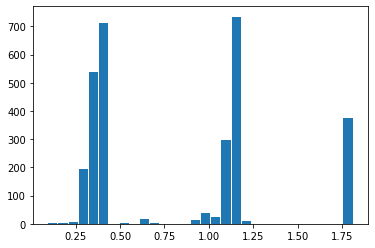

In [5]:
plt.hist(target, bins = 30, rwidth = 0.9);

In [3]:
def read_pymatgen_dict(file):
    with open(file, "r") as f:
        d = json.load(f)
    return Structure.from_dict(d)

In [4]:
def prepare_dataset(dataset_path):
    dataset_path = Path(dataset_path)
    targets = pd.read_csv(dataset_path / "targets.csv", index_col=0)
    struct = {
        item.name.strip(".json"): read_pymatgen_dict(item) for item in (dataset_path / "structures").iterdir()
    }

    data = pd.DataFrame(columns=["structures"], index=struct.keys())
    data = data.assign(structures=struct.values(), targets=targets)

    return data

In [5]:
data = prepare_dataset(path_public)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [319]:
path_to = './data/vasp/'
for it in os.listdir(path_public + 'structures/'):
#     structure = read_pymatgen_dict(path_public + 'structures/' + it)
    with open(path_public + 'structures/' + it, "r") as f:
        inc = inputs.Incar()
        inc = inc.from_dict(json.load(f))
    inc.write_file(path_to + it[:-5] + '.vasp')
#     w = CifWriter(structure)
#     w.write_file(path_to + it[:-5] + '.cif')

In [5]:
path_to = './data/poscar_private/'
for it in os.listdir(path_private + 'structures/'):
    with open(path_private + 'structures/' + it, "r") as f:
        structure = Structure.from_dict(json.load(f))
    structure.to(fmt='poscar', filename = path_to + it[:-5] + '.vasp')

In [138]:
w = CifWriter(structure)
w.write_file('mystructure.cif')

In [57]:
structure.formula

'Mo63 S128'

In [221]:
structure = structure.as_dict()

In [63]:
files = [path_public + 'structures/' +i for i in  os.listdir(path_public + 'structures')]

In [65]:
structures = []
for file in files:
    with open(file, "r") as f:
        d = json.load(f)
        structures += [d]

In [68]:
from tqdm.notebook import tqdm

In [71]:
all_structures = []
for structure in tqdm(structures):
    structure_flattened = dfs(structure)[2:]
    structure_flattened[structure_flattened == 'S'] = '0'
    structure_flattened[structure_flattened == 'Mo'] = '1'
    structure_flattened[structure_flattened == 'Se'] = '2'
    structure_flattened[structure_flattened == 'W'] = '3'
    all_structures += [structure_flattened]

  0%|          | 0/2966 [00:00<?, ?it/s]

In [151]:
max_len = 0
min_len = 10**4
for structure_flattened in all_structures:
    max_len = max(len(structure_flattened), max_len)
    min_len = min(len(structure_flattened), min_len)

all_structures_eq_size = []
for structure_flattened in all_structures:
    all_structures_eq_size += [np.concatenate((structure_flattened, np.full(max_len - len(structure_flattened), '0')))]

x = np.array(all_structures_eq_size).astype(float)

In [105]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [166]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [164]:
x = x[:, :30]

In [163]:
all_structures[0][:50]

array(['25.5225256', '0.0', '1.5628039641098191e-15',
       '-12.761262799999994', '22.10315553833868',
       '1.5628039641098191e-15', '0.0', '0.0', '14.879004', '25.5225256',
       '25.5225256', '14.879004', '90.0', '90.0', '119.99999999999999',
       '8393.668021812642', '1', '1.0', '0.04166667', '0.08333333',
       '0.25', '1.2761262868643541e-07', '1.8419295545177048', '3.719751',
       '1', '1', '1.0', '0.04166667', '0.20833333', '0.25',
       '-1.5951577223873707', '4.60482399681004', '3.7197510000000005',
       '1', '1', '1.0', '0.04166667', '0.3333333333333333', '0.25',
       '-3.1903156149249123', '7.367718512779559', '3.7197510000000005',
       '1', '1', '1.0', '0.04166667', '0.45833333', '0.25',
       '-4.785473422387369', '10.13061288139471'], dtype='<U32')

In [118]:
x.shape

(2966, 100)

In [123]:
np.isnan(x).sum()

0

In [167]:
model = Lasso(0.001)
model.fit(X_train, y_train)
print(mse(model.predict(X_train), y_train))
print(mse(model.predict(X_test), y_test))

0.2596275030181384
0.2532963316464968


In [133]:
mse(y_train, np.full(y_train.shape[0], np.mean(y_train)))

0.25968781852365996

In [138]:
def metrics(y_true, y_pred):
    eps = 0.02
    return np.sum(np.abs(y_true - y_pred) < eps)/len(y_true)

In [144]:
metrics(y_train, np.full(y_train.shape[0], np.mean(y_train)))

0.0

In [155]:
print(metrics(model.predict(X_train), y_train))
print(metrics(model.predict(X_test), y_test))

0.0996477101157524
0.08580183861082738


(2966, 1744)

In [88]:
json_normalize(structure)

,@module,@class,charge,sites,lattice.matrix,lattice.a,lattice.b,lattice.c,lattice.alpha,lattice.beta,lattice.gamma,lattice.volume
0,pymatgen.core.structure,Structure,None,"[{'species': [{'element': 'Mo', 'occu': 1.0}],...","[[25.5225256, 0.0, 1.5628039641098191e-15], [-...",25.522526,25.522526,14.879004,90.0,90.0,120.0,8393.668022


In [93]:
structure['sites']

[{'species': [{'element': 'Mo', 'occu': 1.0}],
  'abc': [0.04166667, 0.08333333, 0.25],
  'xyz': [1.2761262868643541e-07, 1.8419295545177048, 3.719751],
  'label': 'Mo',
  'properties': {}},
 {'species': [{'element': 'Mo', 'occu': 1.0}],
  'abc': [0.04166667, 0.20833333, 0.25],
  'xyz': [-1.5951577223873707, 4.60482399681004, 3.7197510000000005],
  'label': 'Mo',
  'properties': {}},
 {'species': [{'element': 'Mo', 'occu': 1.0}],
  'abc': [0.04166667, 0.3333333333333333, 0.25],
  'xyz': [-3.1903156149249123, 7.367718512779559, 3.7197510000000005],
  'label': 'Mo',
  'properties': {}},
 {'species': [{'element': 'Mo', 'occu': 1.0}],
  'abc': [0.04166667, 0.45833333, 0.25],
  'xyz': [-4.785473422387369, 10.13061288139471, 3.719751000000001],
  'label': 'Mo',
  'properties': {}},
 {'species': [{'element': 'Mo', 'occu': 1.0}],
  'abc': [0.04166667, 0.58333333, 0.25],
  'xyz': [-6.380631272387367, 12.893507323687045, 3.719751000000001],
  'label': 'Mo',
  'properties': {}},
 {'species': [{'e

In [110]:
columns = ['lattice.a','lattice.b','lattice.c','lattice.alpha','lattice.beta', 'lattice.gamma', 'lattice.volume']

In [111]:
df=pd.DataFrame(np.zeros([1,len(columns)]), columns=columns)

In [112]:
df

,lattice.a,lattice.b,lattice.c,lattice.alpha,lattice.beta,lattice.gamma,lattice.volume
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
from pymatgen.io.cif import CifWriter

In [136]:
w = CifWriter(structure)
w.write_file('mystructure.cif')

AttributeError: 'dict' object has no attribute 'lattice'

In [24]:
def dfs(elem):
    ans = np.array([])
    if type(elem) in [str, float, int]:
        return elem
    if type(elem) == list:
        for el in elem:
            ans = np.append(ans, dfs(el))
    if type(elem) == dict:
        for el in elem.keys():
            ans = np.append(ans, dfs(elem[el]))
    
    return ans

In [7]:
structures = data['structures'].to_numpy()

In [8]:
structure = structures[0].as_dict()

In [13]:
type(structure['@module']) == str

True

In [47]:
structure_flattened = dfs(structure)[2:]
structure_flattened[structure_flattened == 'S'] = '0'
structure_flattened[structure_flattened == 'Mo'] = '1'

In [49]:
x = np.array([float(s) for s in structure_flattened])

In [51]:
x.shape

(1727,)

In [37]:
structure

{'@module': 'pymatgen.core.structure',
 '@class': 'Structure',
 'charge': 0.0,
 'lattice': {'matrix': [[25.5225256, 0.0, 1.5628039641098191e-15],
   [-12.761262799999994, 22.10315553833868, 1.5628039641098191e-15],
   [0.0, 0.0, 14.879004]],
  'a': 25.5225256,
  'b': 25.5225256,
  'c': 14.879004,
  'alpha': 90.0,
  'beta': 90.0,
  'gamma': 119.99999999999999,
  'volume': 8393.668021812642},
 'sites': [{'species': [{'element': 'Mo', 'occu': 1.0}],
   'abc': [0.04166667, 0.08333333, 0.25],
   'xyz': [1.2761262868643541e-07, 1.8419295545177048, 3.719751],
   'label': 'Mo',
   'properties': {}},
  {'species': [{'element': 'Mo', 'occu': 1.0}],
   'abc': [0.04166667, 0.20833333, 0.25],
   'xyz': [-1.5951577223873707, 4.60482399681004, 3.7197510000000005],
   'label': 'Mo',
   'properties': {}},
  {'species': [{'element': 'Mo', 'occu': 1.0}],
   'abc': [0.04166667, 0.3333333333333333, 0.25],
   'xyz': [-3.1903156149249123, 7.367718512779559, 3.7197510000000005],
   'label': 'Mo',
   'properti

In [17]:
from functools import reduce
l = [[1,2,3], [4,5,6], [7], [8,9]]
reduce(lambda x, y: x+y, dfs(structure))

TypeError: can only concatenate str (not "float") to str

In [1]:
elem

NameError: name 'elem' is not defined

In [232]:
for elem in structure.keys():
    print(elem)
    print(type(structure[elem]) in [str, float, int])

@module
True
@class
True
charge
True
lattice
False
sites
False


In [128]:
data = {}
for structure in structures[:1]:
    lattice = structure['lattice']
    x = []
    lattice_columns = ['a','b','c','alpha','beta', 'gamma', 'volume']
    for c in lattice_columns:
        
        x += [lattice[c]]
    sites = structure['sites']
    print(x)

[25.5225256, 25.5225256, 14.879004, 90.0, 90.0, 119.99999999999999, 8393.668021812642]


In [ ]:
df

In [133]:
df.loc[0] = x

ValueError: cannot set using a list-like indexer with a different length than the value

In [124]:
df.append(x, ignore_index=True)

,0,lattice.a,lattice.alpha,lattice.b,lattice.beta,lattice.c,lattice.gamma,lattice.volume
0,NaN,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,25.522526,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25.522526,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14.879004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,90.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,120.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8393.668022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,25.522526,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,25.522526,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
files = [path_public+'structures/' + file for file in os.listdir(path_public+'structures')]

In [291]:
structure

{'@module': 'pymatgen.core.structure',
 '@class': 'Structure',
 'charge': None,
 'lattice': {'matrix': [[25.5225256, 0.0, 1.5628039641098191e-15],
   [-12.761262799999994, 22.10315553833868, 1.5628039641098191e-15],
   [0.0, 0.0, 14.879004]],
  'a': 25.5225256,
  'b': 25.5225256,
  'c': 14.879004,
  'alpha': 90.0,
  'beta': 90.0,
  'gamma': 119.99999999999999,
  'volume': 8393.668021812642},
 'sites': [{'species': [{'element': 'Mo', 'occu': 1.0}],
   'abc': [0.04166667, 0.08333333, 0.25],
   'xyz': [1.2761262868643541e-07, 1.8419295545177048, 3.719751],
   'label': 'Mo',
   'properties': {}},
  {'species': [{'element': 'Mo', 'occu': 1.0}],
   'abc': [0.04166667, 0.20833333, 0.25],
   'xyz': [-1.5951577223873707, 4.60482399681004, 3.7197510000000005],
   'label': 'Mo',
   'properties': {}},
  {'species': [{'element': 'Mo', 'occu': 1.0}],
   'abc': [0.04166667, 0.3333333333333333, 0.25],
   'xyz': [-3.1903156149249123, 7.367718512779559, 3.7197510000000005],
   'label': 'Mo',
   'propert

In [13]:
read_pymatgen_dict(files[0])

Structure Summary
Lattice
    abc : 25.5225256 25.5225256 14.879004
 angles : 90.0 90.0 119.99999999999999
 volume : 8393.668021812642
      A : 25.5225256 0.0 1.5628039641098191e-15
      B : -12.761262799999994 22.10315553833868 1.5628039641098191e-15
      C : 0.0 0.0 14.879004
PeriodicSite: Mo (0.0000, 1.8419, 3.7198) [0.0417, 0.0833, 0.2500]
PeriodicSite: Mo (-1.5952, 4.6048, 3.7198) [0.0417, 0.2083, 0.2500]
PeriodicSite: Mo (-3.1903, 7.3677, 3.7198) [0.0417, 0.3333, 0.2500]
PeriodicSite: Mo (-4.7855, 10.1306, 3.7198) [0.0417, 0.4583, 0.2500]
PeriodicSite: Mo (-6.3806, 12.8935, 3.7198) [0.0417, 0.5833, 0.2500]
PeriodicSite: Mo (-7.9758, 15.6564, 3.7198) [0.0417, 0.7083, 0.2500]
PeriodicSite: Mo (-9.5709, 18.4193, 3.7198) [0.0417, 0.8333, 0.2500]
PeriodicSite: Mo (-11.1661, 21.1822, 3.7198) [0.0417, 0.9583, 0.2500]
PeriodicSite: Mo (3.1903, 1.8419, 3.7198) [0.1667, 0.0833, 0.2500]
PeriodicSite: Mo (1.5952, 4.6048, 3.7198) [0.1667, 0.2083, 0.2500]
PeriodicSite: Mo (0.0000, 7.3677, 3

In [16]:
import json
from pathlib import Path

In [162]:
with open('./jarvis-dft/d3-3-12-2021.json', 'r') as f:
    data = json.load(f)

In [189]:
formulas = np.array([atom['formula'] for atom in data])

In [198]:
ind = [((formula[:2] == 'Mo') & (formula[2:3] == 'S')) for formula in formulas]

In [200]:
len(formulas[ind])

41

In [215]:
n = np.array([len(d['atoms']['elements']) for d in data])

In [218]:
formulas[(n > 50) & ind]

array([], dtype='<U19')

In [286]:
structure = structures[460]

In [287]:
coord = np.array([np.array(site['xyz']) for site in structure['sites']])
colors = np.array([np.array(site['label']) for site in structure['sites']])

In [288]:
colors[colors == 'S'] = 'r'
colors[colors == 'Mo'] = 'b'
colors[colors == 'Se'] = 'm'
colors[colors == 'W'] = 'y'

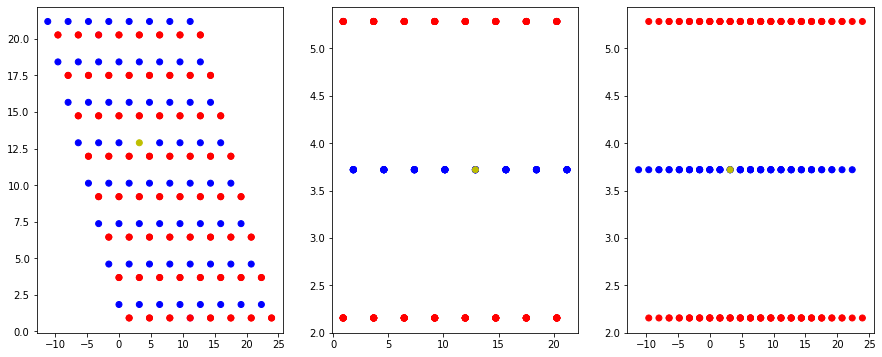

In [289]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (15, 6))
ax0.scatter(*coord[:, [0,1]].T, c = colors)
ax1.scatter(*coord[:, [1,2]].T, c = colors)
ax2.scatter(*coord[:, [0, 2]].T, c = colors)
fig.set_label(['1','2','3','4'])

In [281]:
coord.shape

(189, 3)

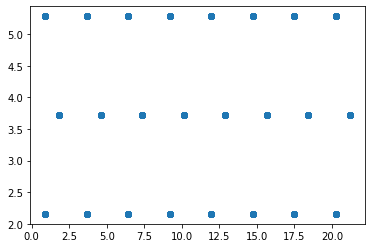

In [181]:
plt.scatter(*coord[:, [1,2]].T)

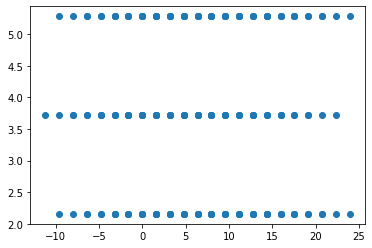

In [180]:
plt.scatter(*coord[:, [0, 2]].T)